### 3. Data Aquisition

#### C. Map Data

Data acquired on [NSW data archive](https://data.gov.au/dataset/ds-dga-bdcf5b09-89bc-47ec-9281-6b8e9ee147aa/details).

This appears to be simple but is the base of our target. This project is not as simple or straight forward as others. 
The target is a compound of events happening on a **specific** time and **place**. For this reason this is a critical step. The size of the area is a compromise between granilarity and computational expense.

Importing libraries

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

import geopandas as gpd
from shapely.geometry import MultiPoint, MultiLineString, MultiPolygon, box, Point, LineString, Polygon

%matplotlib inline

In [2]:
# loading in the state poligon
nsw = gpd.read_file('./data/map/NSW/state/NSW_STATE_POLYGON_shp.shp')
nsw

,ST_PLY_PID,DT_CREATE,DT_RETIRE,STATE_PID,NSW_STATE_,NSW_STAT_1,NSW_STAT_2,NSW_STAT_3,geometry
0,12384,2006-01-12,None,1,2006-01-12,None,NEW SOUTH WALES,NSW,"POLYGON ((150.07240 -36.46528, 150.07238 -36.4..."
1,12385,2006-01-12,None,1,2006-01-12,None,NEW SOUTH WALES,NSW,"POLYGON ((152.56741 -32.22442, 152.56759 -32.2..."
2,12386,2006-01-12,None,1,2006-01-12,None,NEW SOUTH WALES,NSW,"POLYGON ((153.08446 -30.89781, 153.08453 -30.8..."
3,12387,2006-01-12,None,1,2006-01-12,None,NEW SOUTH WALES,NSW,"POLYGON ((150.14784 -36.23360, 150.14786 -36.2..."
4,12388,2006-01-12,None,1,2006-01-12,None,NEW SOUTH WALES,NSW,"POLYGON ((150.07268 -36.46063, 150.07272 -36.4..."
...,...,...,...,...,...,...,...,...,...
314,12620,2006-01-12,None,1,2006-01-12,None,NEW SOUTH WALES,NSW,"POLYGON ((152.54456 -32.34899, 152.54471 -32.3..."
315,12621,2006-01-12,None,1,2006-01-12,None,NEW SOUTH WALES,NSW,"POLYGON ((153.15369 -30.24243, 153.15371 -30.2..."
316,12622,2006-01-12,None,1,2006-01-12,None,NEW SOUTH WALES,NSW,"POLYGON ((150.14291 -36.27146, 150.14295 -36.2..."
317,12623,2006-01-12,None,1,2006-01-12,None,NEW SOUTH WALES,NSW,"POLYGON ((152.14634 -32.76551, 152.14644 -32.7..."


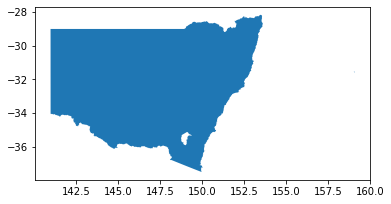

In [3]:
# There is am island far from the coast that is making the plot long.
nsw.plot()

### Preparing the state map

1. <a href='#Drop_island'>Taking islands far from the coast from the plot</a>
2. <a href='#Binnign'>Binning the state</a>
3. <a href='#Centroids'>Adding centroid position</a>


<a id='Drop_island'></a>

#### 1. Taking islands far from the coast from the plot

There is one island far from the coast that has no events (see the [satelite](./Bushfire_Satelite.ipynb) notebook).

In [14]:
# Getting the furthest longitude we have in the state
nsw.geometry.centroid.x.max()

159.07685739148167

In [16]:
# Double checking to see what is the index number
nsw.geometry.centroid.x == nsw.geometry.centroid.x.max()

0      False
1      False
2      False
3      False
4      False
       ...  
314    False
315    False
316    False
317    False
318     True
Length: 319, dtype: bool

In [19]:
# dropping the island entry
nsw.drop(318, inplace=True)

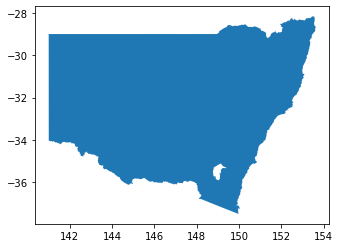

In [20]:
# Looks much better now
nsw.plot()

<a id='Binnign'></a>

#### 2. Binning the state

This is the important part. 

We need to divide the state in equal squares. This first division will be in one degree squares. Smaller squares will give us more granularity, but will also make any computation across the whole DS will be more expensive.

In [23]:
# Function to create the squares in the right position with the right size.
def geo_binning(xmin,ymin,xmax,ymax, length, width):

    # getting the columns and rows set up
    cols = list(range(int(np.floor(xmin)), int(np.ceil(xmax)), width))
    rows = list(range(int(np.floor(ymin)), int(np.ceil(ymax)), length))
    rows.reverse()

    # making the list that will be appended to the dictionary
    polygons = []
    # Iterating through the columns and rows to get the poligons edges
    for x in cols:
        for y in rows:
            polygons.append( Polygon([(x,y), (x+width, y), (x+width, y-length), (x, y-length)]) )
    
            # making a gdf with the poligons
    crs = {'init':'epsg:4283'}
    grid = gpd.GeoDataFrame({'geometry':polygons}, crs=crs)



    # Preparing a magic trick. Getting state limits and coastline
    outer_bounds = gpd.overlay(grid, nsw, how='difference', make_valid=False)
    # Making some magic happen. Overlaying the squares with the state limit to get the coastline and edges
    final_grid = gpd.overlay(grid, outer_bounds, how='difference', make_valid=False)
    print(final_grid.shape)
    return final_grid

In [140]:
%%time
# Preparing the variables for the function
# Limit of the squares
xmin,ymin,xmax,ymax = [140 , -38, 154.10544416, -27.5]
# size of the squres in degrees (1 deree in this case, roughly 111km/degree)
length = 1
width = 1

binned_nsw = geo_binning(xmin,ymin,xmax,ymax, length, width)

C:\Users\julio\anaconda3\envs\geo_env\lib\site-packages\pyproj\crs\crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


(107, 1)
Wall time: 25.5 s


In [141]:
binned_nsw.geometry.centroid.y.min()

-37.217404088050635

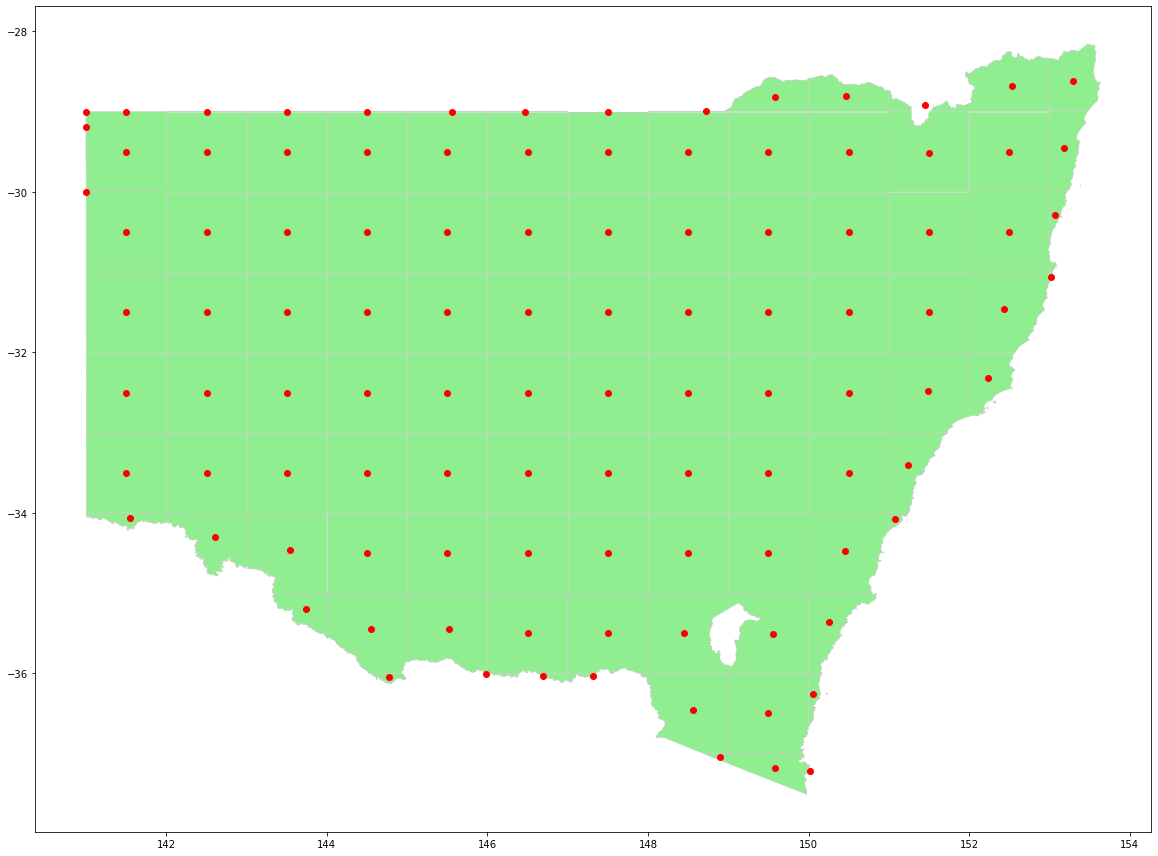

In [142]:
# plottingwith centroids to get a notion of what we got
fig, ax = plt.subplots( figsize=(20, 20))
binned_nsw.plot(color='LightGreen', linewidth=0.5, ax=ax, edgecolor='0.8')
binned_nsw.centroid.plot(ax=ax, color='red')

The trims that are around the ma need to be incorporated as they were in the original map.

We will have to hard code the trims and rests of squares.

In [152]:
binned_nsw.reset_index(inplace=True, drop=True)
grid_c = binned_nsw.copy()

In [153]:
# Replace the edges that are leftover
# inplace=True
grid_c.geometry[0] = grid_c.iloc[[0,1,2,3,4]].unary_union
grid_c.geometry[8] = grid_c.iloc[[8,9]].unary_union
grid_c.geometry[10] = grid_c.iloc[[10,11]].unary_union
grid_c.geometry[15] = grid_c.iloc[[15,16]].unary_union
grid_c.geometry[17] = grid_c.iloc[[17,18]].unary_union
grid_c.geometry[23] = grid_c.iloc[[23,24]].unary_union
grid_c.geometry[25] = grid_c.iloc[[25,26]].unary_union
grid_c.geometry[32] = grid_c.iloc[[32,33]].unary_union
grid_c.geometry[34] = grid_c.iloc[[34,35]].unary_union
grid_c.geometry[41] = grid_c.iloc[[41,42]].unary_union
grid_c.geometry[43] = grid_c.iloc[[43,44]].unary_union
grid_c.geometry[50] = grid_c.iloc[[50,51]].unary_union
grid_c.geometry[52] = grid_c.iloc[[52,53]].unary_union
grid_c.geometry[59] = grid_c.iloc[[59,60]].unary_union
grid_c.geometry[61] = grid_c.iloc[[61,62]].unary_union
grid_c.geometry[69] = grid_c.iloc[[69,70]].unary_union
grid_c.geometry[71] = grid_c.iloc[[71,72]].unary_union
grid_c.geometry[79] = grid_c.iloc[[79,80,89,90]].unary_union
grid_c.geometry[81] = grid_c.iloc[[81,82]].unary_union
grid_c.geometry[87] = grid_c.iloc[[87,88]].unary_union
grid_c.geometry[91] = grid_c.iloc[[91,92]].unary_union
grid_c.geometry[95] = grid_c.iloc[[95,96,97]].unary_union
grid_c.geometry[98] = grid_c.iloc[[98,99]].unary_union
grid_c.geometry[101] = grid_c.iloc[[101,102,106]].unary_union
grid_c.geometry[103] = grid_c.iloc[[103,104,105]].unary_union
# drop duplicate poligons by index
grid_c.drop([1,2,3,4,9,11,16,18,24,26,33,35,42,44,51,53,
             60,62,70,72,80,89,82,88,90,92,96,97,99,102,106,104,105],inplace=True )

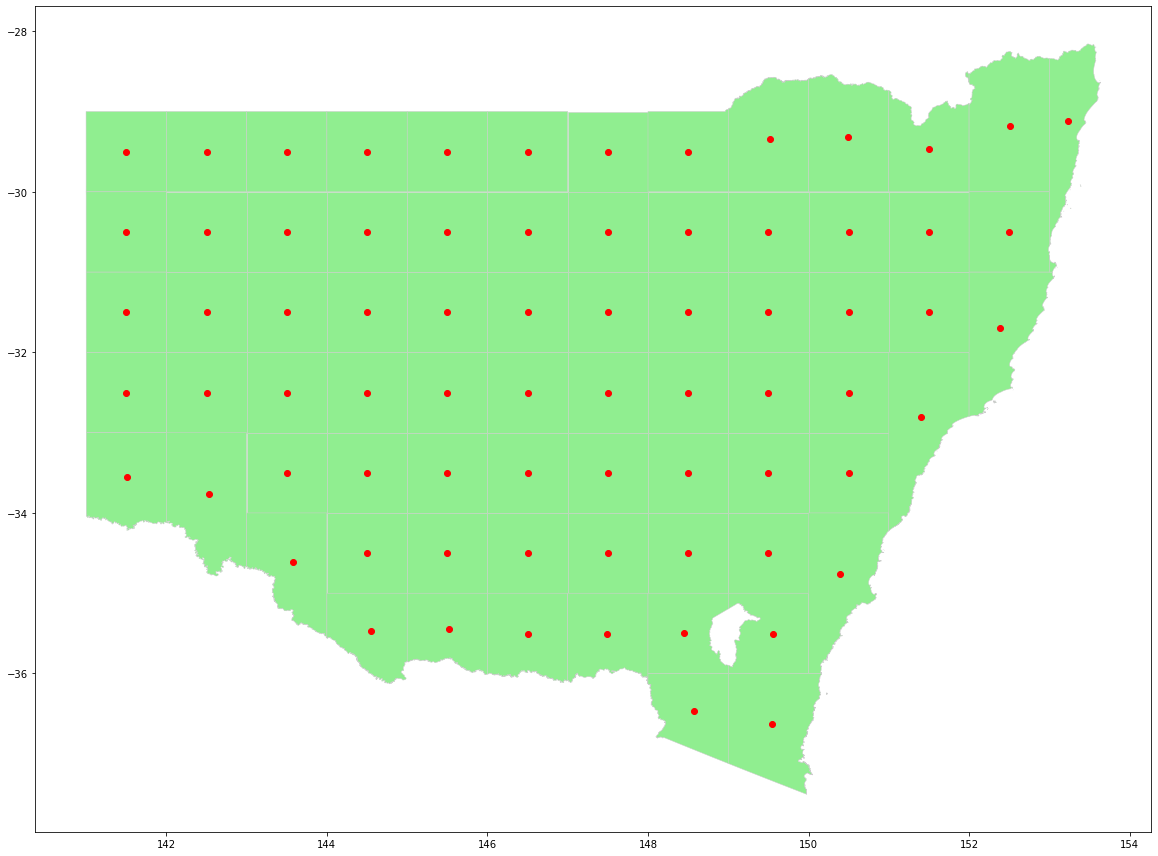

In [158]:
# create figure and axes for Matplotlib
fig, ax = plt.subplots( figsize=(20, 20))
grid_c.plot(color='LightGreen', linewidth=0.5, ax=ax, edgecolor='0.8')
grid_c.centroid.plot(ax=ax, color='red')
# grid_c[10:89].centroid.plot(ax=ax, color='red')

<a id='Centroids'></a>

#### 3. Adding centroid position
This is the area we will model in. It will help greatly if we get the latitude and longitude of the centroids in the dataset.

The target will be the fire in one of the squares.

In [169]:
# Reseting index in case we need it as reference
grid_c.reset_index(inplace=True, drop=True)

In [167]:
grid_c['longitude'] = grid_c.centroid.x
grid_c['latitude'] = grid_c.centroid.y

In [174]:
grid_c.to_file('./data/processed/map/binned_nsw.shp')